In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

RANDOM_STATE = 1

In [2]:
df = pd.read_csv('AER_credit_card_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


In [3]:
df.head(3)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.52,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.42,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.50,0.004156,15.000000,yes,no,4,58,1,5


In [4]:
df.card = df.card.map({'yes': 1, 'no': 0}).astype(int)

In [5]:
train_size = 0.6
val_size = 0.2
test_size = 0.2

NUM_FEATURES = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

X_train, X_test, y_train, y_test = train_test_split(df[NUM_FEATURES], 
                                                    df.card, 
                                                    test_size=test_size, 
                                                    random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=val_size/(test_size+train_size), 
                                                  random_state=RANDOM_STATE)

print(f"Len of train: {len(X_train)}")
print(f"Len of validate: {len(X_val)}")
print(f"Len of test: {len(X_test)}")

Len of train: 791
Len of validate: 264
Len of test: 264


In [6]:
for column in ["reports", "dependents", "active", "share"]:
    fpr, tpr, thresholds = roc_curve(y_train, X_train[column])
    auc_score = auc(x=fpr, y=tpr)
    print(f"{column} AUC: {auc_score}")

reports AUC: 0.28333701393106236
dependents AUC: 0.46722427722262094
active AUC: 0.6043173411362006
share AUC: 0.989183643423692


In [7]:
cols = ["reports", "dependents", "active", "share"]

for column in cols:
    fpr, tpr, thresholds = roc_curve(y_train, X_train[column])
    auc_score = auc(x=fpr, y=tpr)
    print(f"{column} AUC: {auc_score}")

reports AUC: 0.28333701393106236
dependents AUC: 0.46722427722262094
active AUC: 0.6043173411362006
share AUC: 0.989183643423692


In [8]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)

train_dict = X_train.to_dict(orient="records")
val_dict = X_val.to_dict(orient="records")
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [9]:
y_pred = model.predict(X=X_val)
fpr, tpr, thresholds = roc_curve(y_val.values, y_pred)
print(f"AUC score: {auc(fpr, tpr).round(3)}")

AUC score: 0.974


In [10]:
y_pred = model.predict_proba(X=X_val)[:, 1]
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

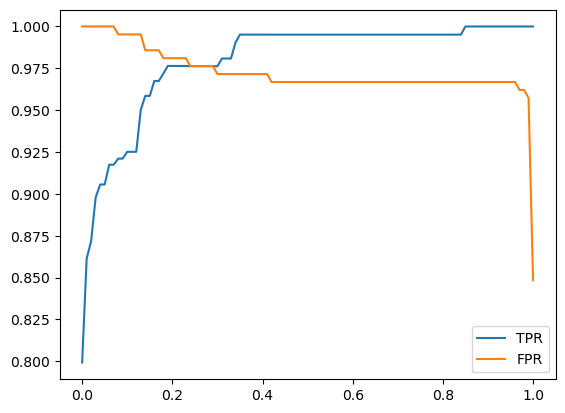

In [11]:
plt.plot(df_scores.threshold, df_scores['p'], label='TPR')
plt.plot(df_scores.threshold, df_scores['r'], label='FPR')
plt.legend()

In [12]:
df_scores['f1'] = (2 * df_scores.p * df_scores.r) / (df_scores.p + df_scores.r)
df_scores[['threshold', 'f1']].sort_values(by='f1', ascending=False).head(1)

,threshold,f1
39,0.39,0.983213


In [13]:
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=1)

In [14]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[NUM_FEATURES].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver="liblinear", C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[NUM_FEATURES].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [15]:
auc_scores = []

for i, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        print(f"Fold {i} AUC: {auc}")
        auc_scores.append(auc)
print(f"Mean AUC: {np.mean(auc_scores)}")
print(f"STD of AUC: {np.std(auc_scores).round(3)}")

Fold 0 AUC: 0.9941860465116279
Fold 1 AUC: 0.9941176470588236
Fold 2 AUC: 0.9943346508563901
Fold 3 AUC: 0.9996107939802803
Fold 4 AUC: 1.0
Mean AUC: 0.9964498276814243
STD of AUC: 0.003


In [16]:
c_values = [0.01, 0.1, 1, 10]
auc_scores = []

for C in c_values:
    for train_idx, val_idx in kfold.split(df_full_train):
            df_train = df_full_train.iloc[train_idx]
            df_val = df_full_train.iloc[val_idx]

            y_train = df_train.card.values
            y_val = df_val.card.values

            dv, model = train(df_train, y_train, C=C)
            y_pred = predict(df_val, dv, model)

            auc = roc_auc_score(y_val, y_pred)
            auc_scores.append(auc)
    print(f"C: {C} Mean AUC: {np.mean(auc_scores).round(3)}, STD of AUC: {np.std(auc_scores).round(3)}")

C: 0.01 Mean AUC: 0.992, STD of AUC: 0.006
C: 0.1 Mean AUC: 0.993, STD of AUC: 0.005
C: 1 Mean AUC: 0.994, STD of AUC: 0.005
C: 10 Mean AUC: 0.995, STD of AUC: 0.004
